In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Data Preparation

In [103]:
data_backups = pd.read_csv('loan_data_2007_2014.csv')
data_backups = data_backups.drop(columns=data_backups.columns[0:1])
data_dict = pd.read_excel('LCDataDictionary.xlsx')

C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\1031781799.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data_backups = pd.read_csv('loan_data_2007_2014.csv')
c:\Users\JV592ML\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [156]:
data = data_backups.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [107]:
#pd.options.display.max_colwidth = None
#pd.options.display.max_rows = None
#data_dict[data_dict['LoanStatNew'] == 'verification_status']
data_dict

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
...,...,...
75,acc_now_delinq,The number of accounts on which the borrower i...
76,tot_coll_amt,Total collection amounts ever owed
77,tot_cur_bal,Total current balance of all accounts
78,NaN,NaN


Data Preprocessing

Continuous Independent Variables

In [155]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [162]:
data['emp_length_int'] = data['emp_length'].str.replace('+ years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace('nan', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year', '')
data['emp_length_int'] = pd.to_numeric(data['emp_length_int'])
data['term_int']  = pd.to_numeric(data['term'].str.replace(' months', ''))
data['emp_length_int'].unique(), data['term_int'].unique()

(array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan]),
 array([36, 60], dtype=int64))

In [163]:
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')
data['mths_since_earliest_cr_line'] = round((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']).dt.days / 30.44)
data['issue_d_date'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['mths_since_issue_d'] = round((pd.to_datetime('2017-12-01') - data['issue_d_date']).dt.days / 30.44)
data['mths_since_earliest_cr_line'].describe(), data['mths_since_issue_d'].describe()

(count    466256.000000
 mean        239.482430
 std          93.974829
 min        -612.000000
 25%         183.000000
 50%         225.000000
 75%         285.000000
 max         587.000000
 Name: mths_since_earliest_cr_line, dtype: float64,
 count    466285.000000
 mean         51.255187
 std          14.340154
 min          36.000000
 25%          41.000000
 50%          47.000000
 75%          57.000000
 max         126.000000
 Name: mths_since_issue_d, dtype: float64)

In [7]:
data.loc[:, ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [164]:
data['mths_since_earliest_cr_line'][data['mths_since_earliest_cr_line'] < 0] = max(data['mths_since_earliest_cr_line'])
data['mths_since_earliest_cr_line'].describe()

C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\930907588.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['mths_since_earliest_cr_line'][data['mths_since_earliest_cr_line'] < 0] = max(data['mths_since_earliest_cr_line'])
C:\User

count    466256.000000
mean        242.385374
std          86.460310
min          73.000000
25%         184.000000
50%         226.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

Discrete Independent Variables

In [144]:
data['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [165]:
data_dummies_list = [pd.get_dummies(data['grade'], prefix= 'grade', prefix_sep= ':'),
                pd.get_dummies(data['sub_grade'], prefix= 'sub_grade', prefix_sep= ':'),
                pd.get_dummies(data['home_ownership'], prefix= 'home_ownership', prefix_sep= ':'),
                pd.get_dummies(data['verification_status'], prefix= 'verification_status', prefix_sep= ':'),
                pd.get_dummies(data['loan_status'], prefix= 'loan_status', prefix_sep= ':'),
                pd.get_dummies(data['purpose'], prefix= 'purpose', prefix_sep= ':'),
                pd.get_dummies(data['addr_state'], prefix= 'addr_state', prefix_sep= ':'),
                pd.get_dummies(data['initial_list_status'], prefix= 'initial_list_status', prefix_sep= ':')]
data_dummies = pd.concat(data_dummies_list, axis = 1)
data = pd.concat([data, data_dummies], axis=1)

In [10]:
#pd.options.display.max_rows = None
data.isna().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                        ..
addr_state:WI            0
addr_state:WV            0
addr_state:WY            0
initial_list_status:f    0
initial_list_status:w    0
Length: 206, dtype: int64

In [166]:
data['total_rev_hi_lim'] = data['total_rev_hi_lim'].fillna(data['funded_amnt'])
data['acc_now_delinq'].fillna(0, inplace=True)
data['total_acc'].fillna(0, inplace=True)
data['pub_rec'].fillna(0, inplace=True)
data['open_acc'].fillna(0, inplace=True)
data['inq_last_6mths'].fillna(0, inplace=True)
data['delinq_2yrs'].fillna(0, inplace=True)
data['emp_length_int'].fillna(0, inplace=True)
data['annual_inc'].fillna(data['annual_inc'][data['annual_inc'].notnull()].mean(), inplace=True)

C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\2339493412.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['acc_now_delinq'].fillna(0, inplace=True)
C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\2339493412.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Dependent Variable

In [14]:
data['loan_status'].value_counts()/data['loan_status'].count()

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: count, dtype: float64

In [167]:
data['good_bad'] = np.where(data['loan_status'].isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 0, 1)
data['good_bad'].value_counts()/data['good_bad'].count()

good_bad
1    0.890693
0    0.109307
Name: count, dtype: float64

WOE Preprocessing

Train Set

Discrete Variables

In [168]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('good_bad', axis=1), data['good_bad'], test_size=0.2, random_state=42)
X_train_prep = X_train

In [176]:
X_train_prep['home_ownership:RENT_OTHER_NONE_ANY'] = X_train_prep['home_ownership:RENT'] + X_train_prep['home_ownership:OTHER'] + X_train_prep['home_ownership:NONE'] + X_train_prep['home_ownership:ANY']

In [169]:
def woe_discrete(X_train_prep, variable, y_train_prep):
    df = pd.concat([X_train_prep[variable], y_train_prep], axis=1)
    df = pd.concat([df.groupby([variable]).count(), df.groupby([variable]).sum()], axis=1).reset_index()
    df.columns = [variable, 'nb_obs', 'nb_good']
    df['nb_bad'] = df['nb_obs'] - df['nb_good']
    df['prop_n_good'] = df['nb_good']/df['nb_good'].sum()
    df['prop_n_bad'] = df['nb_bad']/df['nb_bad'].sum()
    df['WOE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df['IV'] = ((df['prop_n_good'] - df['prop_n_bad'])*df['WOE']).sum()
    df = df.sort_values(by = ['WOE'], ascending=True)
    return df
def woe_continuous(X_train_prep, variable, y_train_prep):
    df = pd.concat([X_train_prep[variable], y_train_prep], axis=1)
    df = pd.concat([df.groupby([variable]).count(), df.groupby([variable]).sum()], axis=1).reset_index()
    df.columns = [variable, 'nb_obs', 'nb_good']
    df['nb_bad'] = df['nb_obs'] - df['nb_good']
    df['prop_n_good'] = df['nb_good']/df['nb_good'].sum()
    df['prop_n_bad'] = df['nb_bad']/df['nb_bad'].sum()
    df['WOE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df['IV'] = ((df['prop_n_good'] - df['prop_n_bad'])*df['WOE']).sum()
    return df
def plot_by_woe(df, rotation_ = 0):
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WOE']
    plt.figure(figsize=(6,3))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'b')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title('Weight of Evidence by ' + df.columns[0])
    plt.xticks(rotation = rotation_)
df_woe = woe_discrete(X_train_prep, 'grade', y_train_prep)
df_woe

,grade,nb_obs,nb_good,nb_bad,prop_n_good,prop_n_bad,WOE,IV
6,G,2654,1932,722,0.005815,0.017706,-1.113459,0.288636
5,F,10530,7944,2586,0.023910,0.063417,-0.975440,0.288636
4,E,28612,23040,5572,0.069345,0.136642,-0.678267,0.288636
3,D,61498,52046,9452,0.156647,0.231792,-0.391843,0.288636
2,C,100245,88794,11451,0.267251,0.280813,-0.049503,0.288636
1,B,109730,101063,8667,0.304178,0.212541,0.358476,0.288636
0,A,59759,57431,2328,0.172855,0.057090,1.107830,0.288636


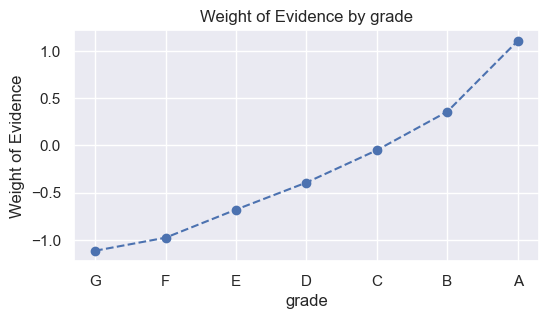

In [134]:
plot_by_woe(df_woe)

In [177]:
if ['addr_state:ND'] in X_train_prep.columns.values:
    pass
else:
    X_train_prep['addr_state:ND'] = 0
X_train_prep['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_train_prep['addr_state:ND'], X_train_prep['addr_state:NE'],
                                                         X_train_prep['addr_state:IA'], X_train_prep['addr_state:NV'],
                                                         X_train_prep['addr_state:FL'], X_train_prep['addr_state:HI'],
                                                         X_train_prep['addr_state:AL']])

X_train_prep['addr_state:NM_VA'] = sum([X_train_prep['addr_state:NM'], X_train_prep['addr_state:VA']])

X_train_prep['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X_train_prep['addr_state:OK'], X_train_prep['addr_state:TN'],
                                              X_train_prep['addr_state:MO'], X_train_prep['addr_state:LA'],
                                              X_train_prep['addr_state:MD'], X_train_prep['addr_state:NC']])

X_train_prep['addr_state:UT_KY_AZ_NJ'] = sum([X_train_prep['addr_state:UT'], X_train_prep['addr_state:KY'],
                                              X_train_prep['addr_state:AZ'], X_train_prep['addr_state:NJ']])

X_train_prep['addr_state:AR_MI_PA_OH_MN'] = sum([X_train_prep['addr_state:AR'], X_train_prep['addr_state:MI'],
                                              X_train_prep['addr_state:PA'], X_train_prep['addr_state:OH'],
                                              X_train_prep['addr_state:MN']])

X_train_prep['addr_state:RI_MA_DE_SD_IN'] = sum([X_train_prep['addr_state:RI'], X_train_prep['addr_state:MA'],
                                              X_train_prep['addr_state:DE'], X_train_prep['addr_state:SD'],
                                              X_train_prep['addr_state:IN']])

X_train_prep['addr_state:GA_WA_OR'] = sum([X_train_prep['addr_state:GA'], X_train_prep['addr_state:WA'],
                                              X_train_prep['addr_state:OR']])

X_train_prep['addr_state:WI_MT'] = sum([X_train_prep['addr_state:WI'], X_train_prep['addr_state:MT']])

X_train_prep['addr_state:IL_CT'] = sum([X_train_prep['addr_state:IL'], X_train_prep['addr_state:CT']])

X_train_prep['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X_train_prep['addr_state:KS'], X_train_prep['addr_state:SC'],
                                              X_train_prep['addr_state:CO'], X_train_prep['addr_state:VT'],
                                              X_train_prep['addr_state:AK'], X_train_prep['addr_state:MS']])

X_train_prep['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X_train_prep['addr_state:WV'], X_train_prep['addr_state:NH'],
                                              X_train_prep['addr_state:WY'], X_train_prep['addr_state:DC'],
                                              X_train_prep['addr_state:ME'], X_train_prep['addr_state:ID']])

In [178]:
X_train_prep['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_train_prep['purpose:educational'], X_train_prep['purpose:small_business'],
                                                                 X_train_prep['purpose:wedding'], X_train_prep['purpose:renewable_energy'],
                                                                 X_train_prep['purpose:moving'], X_train_prep['purpose:house']])
X_train_prep['purpose:oth__med__vacation'] = sum([X_train_prep['purpose:other'], X_train_prep['purpose:medical'],
                                             X_train_prep['purpose:vacation']])
X_train_prep['purpose:major_purch__car__home_impr'] = sum([X_train_prep['purpose:major_purchase'], X_train_prep['purpose:car'],
                                                        X_train_prep['purpose:home_improvement']])

X_train_prep['term_int:36'] = np.where(X_train_prep['term_int'] == 36, 1, 0)
X_train_prep['term_int:60'] = np.where(X_train_prep['term_int'] == 60, 1, 0)

In [179]:
X_train_prep['emp_length:0'] = np.where(X_train_prep['emp_length_int'].isin([0]), 1, 0)
X_train_prep['emp_length:1'] = np.where(X_train_prep['emp_length_int'].isin([1]), 1, 0)
X_train_prep['emp_length:2-4'] = np.where(X_train_prep['emp_length_int'].isin(range(2, 5)), 1, 0)
X_train_prep['emp_length:5-6'] = np.where(X_train_prep['emp_length_int'].isin(range(5, 7)), 1, 0)
X_train_prep['emp_length:7-9'] = np.where(X_train_prep['emp_length_int'].isin(range(7, 10)), 1, 0)
X_train_prep['emp_length:10'] = np.where(X_train_prep['emp_length_int'].isin([10]), 1, 0)

X_train_prep['mths_since_issue_d:<38'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(38)), 1, 0)
X_train_prep['mths_since_issue_d:38-39'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
X_train_prep['mths_since_issue_d:40-41'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
X_train_prep['mths_since_issue_d:42-48'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
X_train_prep['mths_since_issue_d:49-52'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
X_train_prep['mths_since_issue_d:53-64'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
X_train_prep['mths_since_issue_d:65-84'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
X_train_prep['mths_since_issue_d:>84'] = np.where(X_train_prep['mths_since_issue_d'].isin(range(85, int(X_train_prep['mths_since_issue_d'].max()))), 1, 0)

X_train_prep['int_rate:<9.548'] = np.where((X_train_prep['int_rate'] <= 9.548), 1, 0)
X_train_prep['int_rate:9.548-12.025'] = np.where((X_train_prep['int_rate'] > 9.548) & (X_train_prep['int_rate'] <= 12.025), 1, 0)
X_train_prep['int_rate:12.025-15.74'] = np.where((X_train_prep['int_rate'] > 12.025) & (X_train_prep['int_rate'] <= 15.74), 1, 0)
X_train_prep['int_rate:15.74-20.281'] = np.where((X_train_prep['int_rate'] > 15.74) & (X_train_prep['int_rate'] <= 20.281), 1, 0)
X_train_prep['int_rate:>20.281'] = np.where((X_train_prep['int_rate'] > 20.281), 1, 0)

X_train_prep['mths_since_earliest_cr_line:<140'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
X_train_prep['mths_since_earliest_cr_line:141-164'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
X_train_prep['mths_since_earliest_cr_line:165-247'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
X_train_prep['mths_since_earliest_cr_line:248-270'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
X_train_prep['mths_since_earliest_cr_line:271-352'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
X_train_prep['mths_since_earliest_cr_line:>352'] = np.where(X_train_prep['mths_since_earliest_cr_line'].isin(range(353, int(X_train_prep['mths_since_earliest_cr_line'].max()))), 1, 0)

X_train_prep['delinq_2yrs:0'] = np.where((X_train_prep['delinq_2yrs'] == 0), 1, 0)
X_train_prep['delinq_2yrs:1-3'] = np.where((X_train_prep['delinq_2yrs'] >= 1) & (X_train_prep['delinq_2yrs'] <= 3), 1, 0)
X_train_prep['delinq_2yrs:>=4'] = np.where((X_train_prep['delinq_2yrs'] >= 9), 1, 0)

X_train_prep['inq_last_6mths:0'] = np.where((X_train_prep['inq_last_6mths'] == 0), 1, 0)
X_train_prep['inq_last_6mths:1-2'] = np.where((X_train_prep['inq_last_6mths'] >= 1) & (X_train_prep['inq_last_6mths'] <= 2), 1, 0)
X_train_prep['inq_last_6mths:3-6'] = np.where((X_train_prep['inq_last_6mths'] >= 3) & (X_train_prep['inq_last_6mths'] <= 6), 1, 0)
X_train_prep['inq_last_6mths:>6'] = np.where((X_train_prep['inq_last_6mths'] > 6), 1, 0)

X_train_prep['open_acc:0'] = np.where((X_train_prep['open_acc'] == 0), 1, 0)
X_train_prep['open_acc:1-3'] = np.where((X_train_prep['open_acc'] >= 1) & (X_train_prep['open_acc'] <= 3), 1, 0)
X_train_prep['open_acc:4-12'] = np.where((X_train_prep['open_acc'] >= 4) & (X_train_prep['open_acc'] <= 12), 1, 0)
X_train_prep['open_acc:13-17'] = np.where((X_train_prep['open_acc'] >= 13) & (X_train_prep['open_acc'] <= 17), 1, 0)
X_train_prep['open_acc:18-22'] = np.where((X_train_prep['open_acc'] >= 18) & (X_train_prep['open_acc'] <= 22), 1, 0)
X_train_prep['open_acc:23-25'] = np.where((X_train_prep['open_acc'] >= 23) & (X_train_prep['open_acc'] <= 25), 1, 0)
X_train_prep['open_acc:26-30'] = np.where((X_train_prep['open_acc'] >= 26) & (X_train_prep['open_acc'] <= 30), 1, 0)
X_train_prep['open_acc:>=31'] = np.where((X_train_prep['open_acc'] >= 31), 1, 0)

X_train_prep['pub_rec:0-2'] = np.where((X_train_prep['pub_rec'] >= 0) & (X_train_prep['pub_rec'] <= 2), 1, 0)
X_train_prep['pub_rec:3-4'] = np.where((X_train_prep['pub_rec'] >= 3) & (X_train_prep['pub_rec'] <= 4), 1, 0)
X_train_prep['pub_rec:>=5'] = np.where((X_train_prep['pub_rec'] >= 5), 1, 0)

X_train_prep['total_acc:<=27'] = np.where((X_train_prep['total_acc'] <= 27), 1, 0)
X_train_prep['total_acc:28-51'] = np.where((X_train_prep['total_acc'] >= 28) & (X_train_prep['total_acc'] <= 51), 1, 0)
X_train_prep['total_acc:>=52'] = np.where((X_train_prep['total_acc'] >= 52), 1, 0)

X_train_prep['acc_now_delinq:0'] = np.where((X_train_prep['acc_now_delinq'] == 0), 1, 0)
X_train_prep['acc_now_delinq:>=1'] = np.where((X_train_prep['acc_now_delinq'] >= 1), 1, 0)

X_train_prep['total_rev_hi_lim:<=5K'] = np.where((X_train_prep['total_rev_hi_lim'] <= 5000), 1, 0)
X_train_prep['total_rev_hi_lim:5K-10K'] = np.where((X_train_prep['total_rev_hi_lim'] > 5000) & (X_train_prep['total_rev_hi_lim'] <= 10000), 1, 0)
X_train_prep['total_rev_hi_lim:10K-20K'] = np.where((X_train_prep['total_rev_hi_lim'] > 10000) & (X_train_prep['total_rev_hi_lim'] <= 20000), 1, 0)
X_train_prep['total_rev_hi_lim:20K-30K'] = np.where((X_train_prep['total_rev_hi_lim'] > 20000) & (X_train_prep['total_rev_hi_lim'] <= 30000), 1, 0)
X_train_prep['total_rev_hi_lim:30K-40K'] = np.where((X_train_prep['total_rev_hi_lim'] > 30000) & (X_train_prep['total_rev_hi_lim'] <= 40000), 1, 0)
X_train_prep['total_rev_hi_lim:40K-55K'] = np.where((X_train_prep['total_rev_hi_lim'] > 40000) & (X_train_prep['total_rev_hi_lim'] <= 55000), 1, 0)
X_train_prep['total_rev_hi_lim:55K-95K'] = np.where((X_train_prep['total_rev_hi_lim'] > 55000) & (X_train_prep['total_rev_hi_lim'] <= 95000), 1, 0)
X_train_prep['total_rev_hi_lim:>95K'] = np.where((X_train_prep['total_rev_hi_lim'] > 95000), 1, 0)

X_train_prep['annual_inc:<20K'] = np.where((X_train_prep['annual_inc'] <= 20000), 1, 0)
X_train_prep['annual_inc:20K-30K'] = np.where((X_train_prep['annual_inc'] > 20000) & (X_train_prep['annual_inc'] <= 30000), 1, 0)
X_train_prep['annual_inc:30K-40K'] = np.where((X_train_prep['annual_inc'] > 30000) & (X_train_prep['annual_inc'] <= 40000), 1, 0)
X_train_prep['annual_inc:40K-50K'] = np.where((X_train_prep['annual_inc'] > 40000) & (X_train_prep['annual_inc'] <= 50000), 1, 0)
X_train_prep['annual_inc:50K-60K'] = np.where((X_train_prep['annual_inc'] > 50000) & (X_train_prep['annual_inc'] <= 60000), 1, 0)
X_train_prep['annual_inc:60K-70K'] = np.where((X_train_prep['annual_inc'] > 60000) & (X_train_prep['annual_inc'] <= 70000), 1, 0)
X_train_prep['annual_inc:70K-80K'] = np.where((X_train_prep['annual_inc'] > 70000) & (X_train_prep['annual_inc'] <= 80000), 1, 0)
X_train_prep['annual_inc:80K-90K'] = np.where((X_train_prep['annual_inc'] > 80000) & (X_train_prep['annual_inc'] <= 90000), 1, 0)
X_train_prep['annual_inc:90K-100K'] = np.where((X_train_prep['annual_inc'] > 90000) & (X_train_prep['annual_inc'] <= 100000), 1, 0)
X_train_prep['annual_inc:100K-120K'] = np.where((X_train_prep['annual_inc'] > 100000) & (X_train_prep['annual_inc'] <= 120000), 1, 0)
X_train_prep['annual_inc:120K-140K'] = np.where((X_train_prep['annual_inc'] > 120000) & (X_train_prep['annual_inc'] <= 140000), 1, 0)
X_train_prep['annual_inc:>140K'] = np.where((X_train_prep['annual_inc'] > 140000), 1, 0)

X_train_prep['mths_since_last_delinq:Missing'] = np.where((X_train_prep['mths_since_last_delinq'].isnull()), 1, 0)
X_train_prep['mths_since_last_delinq:0-3'] = np.where((X_train_prep['mths_since_last_delinq'] >= 0) & (X_train_prep['mths_since_last_delinq'] <= 3), 1, 0)
X_train_prep['mths_since_last_delinq:4-30'] = np.where((X_train_prep['mths_since_last_delinq'] >= 4) & (X_train_prep['mths_since_last_delinq'] <= 30), 1, 0)
X_train_prep['mths_since_last_delinq:31-56'] = np.where((X_train_prep['mths_since_last_delinq'] >= 31) & (X_train_prep['mths_since_last_delinq'] <= 56), 1, 0)
X_train_prep['mths_since_last_delinq:>=57'] = np.where((X_train_prep['mths_since_last_delinq'] >= 57), 1, 0)

X_train_prep['dti:<=1.4'] = np.where((X_train_prep['dti'] <= 1.4), 1, 0)
X_train_prep['dti:1.4-3.5'] = np.where((X_train_prep['dti'] > 1.4) & (X_train_prep['dti'] <= 3.5), 1, 0)
X_train_prep['dti:3.5-7.7'] = np.where((X_train_prep['dti'] > 3.5) & (X_train_prep['dti'] <= 7.7), 1, 0)
X_train_prep['dti:7.7-10.5'] = np.where((X_train_prep['dti'] > 7.7) & (X_train_prep['dti'] <= 10.5), 1, 0)
X_train_prep['dti:10.5-16.1'] = np.where((X_train_prep['dti'] > 10.5) & (X_train_prep['dti'] <= 16.1), 1, 0)
X_train_prep['dti:16.1-20.3'] = np.where((X_train_prep['dti'] > 16.1) & (X_train_prep['dti'] <= 20.3), 1, 0)
X_train_prep['dti:20.3-21.7'] = np.where((X_train_prep['dti'] > 20.3) & (X_train_prep['dti'] <= 21.7), 1, 0)
X_train_prep['dti:21.7-22.4'] = np.where((X_train_prep['dti'] > 21.7) & (X_train_prep['dti'] <= 22.4), 1, 0)
X_train_prep['dti:22.4-35'] = np.where((X_train_prep['dti'] > 22.4) & (X_train_prep['dti'] <= 35), 1, 0)
X_train_prep['dti:>35'] = np.where((X_train_prep['dti'] > 35), 1, 0)

X_train_prep['mths_since_last_record:Missing'] = np.where((X_train_prep['mths_since_last_record'].isnull()), 1, 0)
X_train_prep['mths_since_last_record:0-2'] = np.where((X_train_prep['mths_since_last_record'] >= 0) & (X_train_prep['mths_since_last_record'] <= 2), 1, 0)
X_train_prep['mths_since_last_record:3-20'] = np.where((X_train_prep['mths_since_last_record'] >= 3) & (X_train_prep['mths_since_last_record'] <= 20), 1, 0)
X_train_prep['mths_since_last_record:21-31'] = np.where((X_train_prep['mths_since_last_record'] >= 21) & (X_train_prep['mths_since_last_record'] <= 31), 1, 0)
X_train_prep['mths_since_last_record:32-80'] = np.where((X_train_prep['mths_since_last_record'] >= 32) & (X_train_prep['mths_since_last_record'] <= 80), 1, 0)
X_train_prep['mths_since_last_record:81-86'] = np.where((X_train_prep['mths_since_last_record'] >= 81) & (X_train_prep['mths_since_last_record'] <= 86), 1, 0)
X_train_prep['mths_since_last_record:>=86'] = np.where((X_train_prep['mths_since_last_record'] >= 86), 1, 0)

C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\118373813.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_prep['dti:3.5-7.7'] = np.where((X_train_prep['dti'] > 3.5) & (X_train_prep['dti'] <= 7.7), 1, 0)
C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\118373813.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_prep['dti:7.7-10.5'] = np.where((X_train_prep['dti'] > 7.7) & (X_train_prep['dti'] <= 10.5), 1, 0)
C:\Users\JV592ML\AppData\Local\Temp\ipykernel_28280\118373813.py:91: PerformanceWarning: Dat

Test Set

In [173]:
X_train_prep_preprocessed = X_train_prep

In [175]:
X_train_prep = X_test
#run the previous preprocessing steps

In [180]:
X_test_prep_preprocessed = X_train_prep

In [181]:
X_train_prep_preprocessed.to_csv('loan_data_inputs_train.csv')
y_train.to_csv('loan_data_targets_train.csv')
X_test_prep_preprocessed.to_csv('loan_data_inputs_test.csv')
y_test.to_csv('loan_data_targets_test.csv')